# Project: Predicting Stock Price & Return  
Feature Creation
## ver 0.3  
All guidance and guildlines provided by Romeo Kienzler

### Guidance - Feature Creation  
This task transforms input columns of various relations into additional columns to improve model performance. A subset of those features can be created in an initial task (for example, one-hot encoding of categorical variables or normalization of numerical variables). Some others require business understanding or multiple iterations to be considered. This task is one of those benefiting the most from the highly iterative nature of this method.

### Guildlines for feature transformation  
- Imputing  
Some algoriths are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution  
- Imputed time-seies quantization  
Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common "heart beat: and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps  
- Scaling / Normalizing / Centering  
Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one  
- Filtering  
Sometimes imputing values doesn't perform well, therefore deletion of low quality records is a better strategy  
- Discretizing  
Continuous fileds might confuse the model, e.g. a discrete set of age ranges sometimes performs better than continuous values, especially on smaller amounts of data and with simpler models

### Guildlines for feature creation  
- One-hot-enconding  
Categorical integer features should be transformed into "one-hot" vectors. In relational terms this results in additional columns - one columns for each distinct category  
- Time-to-Frequency transformation  
Time-series (and sometimes also sequence data) is recorded in the time domain but can easily transformed into the frequency domain e.g. using FFT (Fast Fourier transformation)  
- Month-From-Date  
Creating an additional feature containing the month independent from data captures seasonal aspects. Sometimes further discretization in to quarters helps as well  
- Aggregate-on-Target  
Simply aggregating fields the target variable (or even other fields) can improve performance, e.g. count number of data points per ZIP code or take the median of all values by geographical region

#### 0.Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import talib

In [2]:
#let the notebook display full length of the data columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#### 1. Create target

In [3]:
df = pd.read_csv("data_transformed.csv", parse_dates=['date'], index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4356 entries, 2003-01-02 to 2019-10-18
Data columns (total 21 columns):
loblaw_price           4356 non-null float64
loblaw_volume          4356 non-null float64
metro_price            4356 non-null float64
metro_volume           4356 non-null float64
empa_price             4356 non-null float64
empa_volume            4356 non-null float64
gwl_price              4356 non-null float64
gwl_volume             4356 non-null float64
atd_price              4356 non-null float64
atd_volume             4356 non-null float64
tsx_price              4356 non-null float64
tsx_volume             4356 non-null float64
sp500_price            4356 non-null float64
sp500_volume           4356 non-null float64
BCPI                   4356 non-null float64
CPI                    4356 non-null float64
bank_interest          4356 non-null float64
CEER                   4356 non-null float64
trend_grocery_store    4104 non-null float64
trend_loblaws       

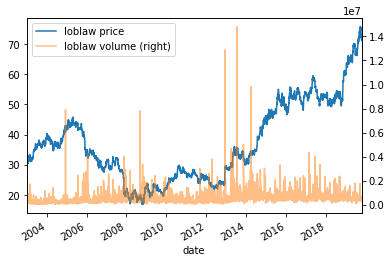

In [4]:
df['loblaw_price'].plot(label = 'loblaw price', legend = True)
df['loblaw_volume'].plot(secondary_y=True, alpha=0.5, label = 'loblaw volume' , legend = True)
plt.show()

In [5]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)
df['loblaw_5d_pct'] = df['loblaw_price'].pct_change(5)

In [6]:
df['loblaw_volume_1d_pct'] = df['loblaw_volume'].pct_change()
df['loblaw_volume_1d_pct_SMA'] = talib.SMA( df['loblaw_volume_1d_pct'].values, timeperiod=5)

In [7]:
for column in ['loblaw_5d_future_pct', 'loblaw_5d_pct', 'loblaw_volume_1d_pct']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    df[column + "_filtered"] = df[column].apply(lambda x: (Q1 - 1.5 * IQR) if x < (Q1 - 1.5 * IQR) else (Q3 + 1.5 * IQR) if x > (Q3 + 1.5 * IQR) else x)

In [8]:
feature_names = []

for n in [14, 30, 50, 200]:
    df['loblaw_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
    df['loblaw_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
    feature_names = feature_names + ['loblaw_ma' + str(n), 'loblaw_rsi' + str(n)]

print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200']


In [9]:
df.dropna(inplace=True)

In [10]:
features_non_filtered = df[feature_names + ['loblaw_5d_pct', 'loblaw_volume_1d_pct']]
targets_non_filtered = df[['loblaw_5d_future_pct']]

In [11]:
features_filtered = df[feature_names + ['loblaw_5d_pct_filtered', 'loblaw_volume_1d_pct_filtered']]
targets_filtered = df[['loblaw_5d_future_pct_filtered']]

In [12]:
features_filtered.shape, targets_filtered.shape

((4099, 10), (4099, 1))

In [13]:
features_non_filtered.shape, targets_non_filtered.shape


((4099, 10), (4099, 1))

In [34]:
df = pd.read_csv("data_transformed.csv", parse_dates=['date'], index_col='date')

In [35]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)
df['loblaw_5d_pct'] = df['loblaw_price'].pct_change(5)

In [36]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    feature_names = feature_names + [stock + '_price']


In [37]:
economic_indecis = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indecis + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_price', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_price', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_price', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_price', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_price', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_price', 'sp500_ma14', 'sp500_rsi14', 'sp500_ma30', 'sp500_rsi30', 'sp500_ma50', 'sp500_rsi50', 'sp500_ma200', 'sp500_rsi200', 'sp500_price', 'BCPI', 'CPI', 'bank_interest', 'CEER', 'trend_grocery_store', 'trend_loblaws', 'trend_stock']


In [38]:
df.dropna(inplace=True)

In [60]:
features = df[feature_names]
targets = df['loblaw_5d_future_pct']

In [61]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [62]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3484, 70) (3484,)
(615, 70) (615,)


In [63]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfr = RandomForestRegressor()

for g in ParameterGrid(grid):
    rfr.set_params(**g)  
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets.values.ravel()))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.0008771750779030807 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


In [53]:
'''
train_features.to_csv("train_features.csv")
train_targets.to_dataframe.to_csv("train_targets.csv")
test_features.to_csv("test_features.csv")
test_targets.to_dataframe.to_csv("train_targets.csv")
'''

In [64]:
df.to_csv("data_feature_created.csv")

In [55]:
train_targets()

TypeError: 'DataFrame' object is not callable

In [29]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaw_5d_pct,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0356,1534500.0,4.9414,23640.0,76.2923,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.4905,-0.015477,0.033511,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472
2004-01-05,39.9635,151800.0,3.9620,171600.0,4.8872,23703.0,74.9241,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,39.7979,-0.004144,0.026577,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252
2004-01-06,39.8748,372500.0,4.0467,2180700.0,4.8330,265395.0,74.5477,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.3132,-0.014084,0.012002,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454
2004-01-07,40.3182,196400.0,4.0560,438000.0,4.8421,62139.0,74.9604,120100.0,1.3094,4084548.0,8388.5000,238648300.0,1126.33,1.704900e+09,369.320,103.357143,4.5,113.09,46.428571,26.714286,16.809524,39.1417,-0.029180,0.023255,0.971544,75.690065,0.938226,66.784726,0.933490,62.222813,0.891446,56.971513,0.971544,75.690065,0.938226,66.784726,0.933490,62.222813,0.891446,56.971513,0.971544,75.690065,0.938226,66.784726,0.933490,62.222813,0.891446,56.971513,0.971544,75.690065,0.938226,66.784726,0.933490,62.222813,0.891446,56.971513,0.971544,75.690065,0.938226,66.784726,0.933490,62.222813,0.891446,56.971513,0.971544,75.690065,0.938226,66.784726,0.933490,62.222813,0.891446,56.971513
2004-01-08,39.9043,450000.0,4.0839,682800.0,4.8511,104016.0,75.4671,87300.0,1.3198,2286000.0,8386.4004,217537000.0,1131.92,1.868400e+09,370.234,103.371429,4.5,113.72,46.285714,26.642857,16.761905,39.2540,-0.016296,0.010478,0.985113,67.819755,0.951018,63.364361,0.944373,60.262313,0.901646,56.520578,0.985113,67.819755,0.951018,63.364361,0.944373,60.262313,0.901646,56.520578,0.985113,67.819755,0.951018,63.36436

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

In [15]:
train_size = int(0.85 * features_filtered.shape[0])
train_features = features_non_filtered[:train_size]
train_targets = targets_non_filtered[:train_size]
test_features = features_non_filtered[train_size:]
test_targets = targets_non_filtered[train_size:]

In [16]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,6,8,10], 'random_state': [42]}
test_scores = []
rfr = RandomForestRegressor()

for g in ParameterGrid(grid):
    rfr.set_params(**g)  
    rfr.fit(train_features, train_targets.values.ravel())
    test_scores.append(rfr.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.02441894957544899 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [17]:
train_size = int(0.85 * features_filtered.shape[0])
train_features = features_filtered[:train_size]
train_targets = targets_filtered[:train_size]
test_features = features_filtered[train_size:]
test_targets = targets_filtered[train_size:]

In [20]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,6,8,10], 'random_state': [42]}
test_scores = []
rfr = RandomForestRegressor()

for g in ParameterGrid(grid):
    rfr.set_params(**g)  
    rfr.fit(train_features, train_targets.values.ravel())
    test_scores.append(rfr.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.02791166795088551 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [19]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(features_non_filtered):
    train_features = features_non_filtered.iloc[train_index]
    train_targets = targets_non_filtered.iloc[train_index]
    test_features = features_non_filtered.iloc[test_index]
    test_targets = targets_non_filtered.iloc[test_index]

    grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
    test_scores = []
    rfr = RandomForestRegressor()

    for g in ParameterGrid(grid):
        rfr.set_params(**g)  # ** is "unpacking" the dictionary
        rfr.fit(train_features, train_targets)
        test_scores.append(rfr.score(test_features, test_targets))

    best_idx = np.argmax(test_scores)
    print(test_scores[best_idx], ParameterGrid(grid)[best_idx])    


/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
-0.04098985818089895 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}
/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), 

In [92]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(features_non_filtered):
    train_features = features_filtered.iloc[train_index]
    train_targets = targets_filtered.iloc[train_index]
    test_features = features_filtered.iloc[test_index]
    test_targets = targets_filtered.iloc[test_index]

    grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
    test_scores = []
    rfr = RandomForestRegressor()

    for g in ParameterGrid(grid):
        rfr.set_params(**g)  # ** is "unpacking" the dictionary
        rfr.fit(train_features, train_targets)
        test_scores.append(rfr.score(test_features, test_targets))

    best_idx = np.argmax(test_scores)
    print(test_scores[best_idx], ParameterGrid(grid)[best_idx])    

/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
-0.08054596471078934 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}
/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), 

In [ ]:


# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []
rfr = RandomForestRegressor()

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

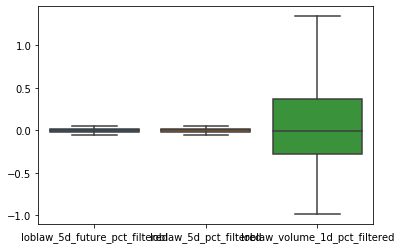

In [45]:
sns.boxplot(data=df[['loblaw_5d_future_pct_filtered', 'loblaw_5d_pct_filtered', 'loblaw_volume_1d_pct_filtered']])

In [29]:
df['loblaw_5d_future_pct'].quantile(0.25), df['loblaw_5d_future_pct'].quantile(0.75)

(-0.013045431297536214, 0.014992679143213006)

In [33]:
corr = df[['loblaw_5d_pct', 'loblaw_5d_future_pct']].corr()
print(corr)

loblaw_5d_pct  loblaw_5d_future_pct
loblaw_5d_pct         1.000000      -0.025631            
loblaw_5d_future_pct -0.025631       1.000000            


In [34]:
corr = df[['loblaw_5d_pct_filtered', 'loblaw_5d_future_pct_filtered']].corr()
print(corr)

loblaw_5d_pct_filtered  loblaw_5d_future_pct_filtered
loblaw_5d_pct_filtered         1.000000               -0.029138                     
loblaw_5d_future_pct_filtered -0.029138                1.000000                     


In [36]:
loblaw_df = df[['loblaw_5d_future_pct'] + feature_names].dropna()
features = loblaw_df[feature_names]
targets = loblaw_df['loblaw_5d_future_pct']

In [37]:
corr = loblaw_df.corr()
print(corr)

loblaw_5d_future_pct  loblaw_5d_pct  loblaw_ma14  loblaw_rsi14  loblaw_ma30  loblaw_rsi30  loblaw_ma50  loblaw_rsi50  loblaw_ma200  loblaw_rsi200
loblaw_5d_future_pct  1.000000             -0.025814      -0.012333     0.003105     -0.008328     0.005128      0.013913     0.011063     -0.008095      0.016651     
loblaw_5d_pct        -0.025814              1.000000      -0.855409     0.657892     -0.651014     0.503336     -0.508196     0.407907     -0.268928      0.216789     
loblaw_ma14          -0.012333             -0.855409       1.000000    -0.832514      0.864789    -0.678718      0.703826    -0.566471      0.392134     -0.320705     
loblaw_rsi14          0.003105              0.657892      -0.832514     1.000000     -0.909980     0.926142     -0.872775     0.817534     -0.570844      0.495501     
loblaw_ma30          -0.008328             -0.651014       0.864789    -0.909980      1.000000    -0.845652      0.923298    -0.747240      0.563115     -0.457417     
loblaw_rsi30  

In [12]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(4156, 10) (3532, 10) (624, 10)


/home/paul/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [13]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

                             OLS Regression Results                             
Dep. Variable:     loblaw_5d_future_pct   R-squared:                       0.019
Model:                              OLS   Adj. R-squared:                  0.016
Method:                   Least Squares   F-statistic:                     7.441
Date:                  Sun, 20 Oct 2019   Prob (F-statistic):           7.68e-11
Time:                          23:45:58   Log-Likelihood:                 7671.7
No. Observations:                  3532   AIC:                        -1.532e+04
Df Residuals:                      3522   BIC:                        -1.526e+04
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0779  

In [15]:
feature_names.extend(['loblaw_volume_1d_pct', 'loblaw_volume_1d_pct_SMA'])

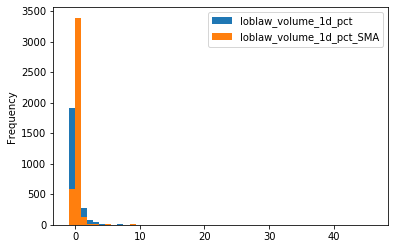

In [16]:
loblaw_df[['loblaw_volume_1d_pct', 'loblaw_volume_1d_pct_SMA']].plot(kind='hist', sharex=False, bins=50)

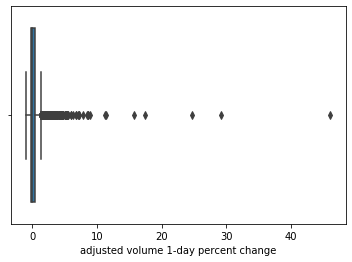

In [17]:
sns.boxplot(loblaw_df['loblaw_volume_1d_pct'])
plt.xlabel('adjusted volume 1-day percent change')
plt.show()

In [18]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(loblaw_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = loblaw_df.index

# Join the dataframe with the days of week dataframe
loblaw_df = pd.concat([loblaw_df, days_of_week], axis=1)

loblaw_df.dropna(inplace=True)  # drop missing values in-place

In [19]:
# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])

In [20]:
loblaw_df.head()

,loblaw_5d_future_pct,loblaw_5d_pct,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_volume_1d_pct,loblaw_volume_1d_pct_SMA,weekday_1,weekday_2,weekday_3,weekday_4
date,,,,,,,,,,,,,,,,
2003-10-23,-0.001578,-0.002675,0.983585,61.577897,0.973791,56.521609,0.979603,55.546015,0.921842,55.463242,-0.012311,0.060062,0,0,1,0
2003-10-24,-0.000783,0.010755,0.979577,65.022482,0.967292,58.297135,0.971845,56.608940,0.915396,55.716001,-0.186969,0.080008,0,0,0,1
2003-10-27,0.006289,0.009044,0.986387,61.462842,0.972971,56.856319,0.976057,55.792369,0.920531,55.526018,-0.395819,-0.098716,0,0,0,0
2003-10-28,0.007881,0.000789,0.990893,59.701956,0.976323,56.138262,0.978147,55.384533,0.923517,55.430984,0.568627,-0.041949,1,0,0,0
2003-10-29,0.021812,0.000316,0.995880,57.570461,0.980060,55.271723,0.980938,54.893189,0.926942,55.316802,0.265441,0.047794,0,1,0,0


In [21]:
loblaw_df.tail(10)

,loblaw_5d_future_pct,loblaw_5d_pct,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_volume_1d_pct,loblaw_volume_1d_pct_SMA,weekday_1,weekday_2,weekday_3,weekday_4
date,,,,,,,,,,,,,,,,
2019-10-07,-0.030688,-0.004638,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.250884,-0.054802,0,0,0,0
2019-10-08,-0.019316,-0.010426,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,0.720491,0.110588,1,0,0,0
2019-10-09,-0.034120,-0.009749,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.207098,0.178590,0,1,0,0
2019-10-10,-0.026284,-0.023537,1.019659,46.888136,1.006795,54.612312,0.986885,56.493298,0.918864,56.625355,-0.103971,0.093303,0,0,1,0
2019-10-11,-0.024517,-0.024582,1.023529,43.916591,1.012795,52.933548,0.993884,55.413363,0.925023,56.325933,-0.276049,0.059337,0,0,0,1
2019-10-14,-0.021770,-0.030688,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,0.021145,0.113743,0,0,0,0
2019-10-15,-0.019008,-0.019316,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,0.020707,-0.026214,1,0,0,0
2019-10-16,-0.005585,-0.034120,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,0.605470,0.053460,0,1,0,0
2019-10-17,-0.003916,-0.026284,1.032423,34.357195,1.032142,47.218225,1.018851,51.665112,0.947907,55.261196,-0.262497,0.021755,0,0,1,0


In [22]:
# Create a size for the training set that is 85% of the total number of samples
features = loblaw_df[feature_names]
targets = loblaw_df['loblaw_5d_future_pct']

train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape)
print(targets.shape, train_targets.shape, test_targets.shape)

(4152, 15) (3529, 15) (623, 15)
(4152,) (3529,) (623,)


In [23]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor(max_depth=3)

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.06582500245247735
-0.03346537819884188


In [24]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []
rfr = RandomForestRegressor()

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.019351372097282216 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [25]:
# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200, max_features=4, max_depth=3, random_state=42)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.06982027078473896
-0.019351372097282216


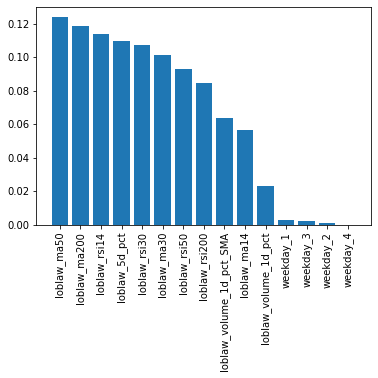

In [26]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [27]:
feature_names = feature_names[:-4]

# Create a size for the training set that is 85% of the total number of samples
features = loblaw_df[feature_names]
targets = loblaw_df['loblaw_5d_future_pct']

train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape)
print(targets.shape, train_targets.shape, test_targets.shape)

(4152, 11) (3529, 11) (623, 11)
(4152,) (3529,) (623,)


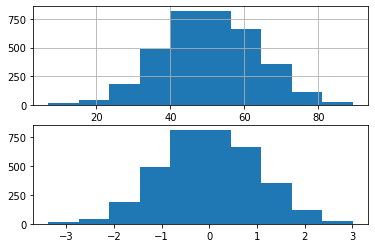

In [28]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [29]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,10):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.7388663948339296
-1.5471882421364862

n_neighbors = 3
train, test scores
0.6133520709969994
-1.2636882584989437

n_neighbors = 4
train, test scores
0.5269506611489649
-1.0446582360475456

n_neighbors = 5
train, test scores
0.46475499656507785
-0.8431314092331632

n_neighbors = 6
train, test scores
0.418828264659219
-0.7168938024576903

n_neighbors = 7
train, test scores
0.3768475641097572
-0.5937228333888618

n_neighbors = 8
train, test scores
0.345493176560168
-0.5032694776806093

n_neighbors = 9
train, test scores
0.3132422137189165
-0.4567912923087374



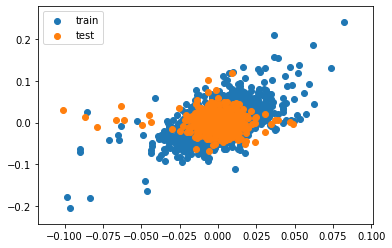

In [30]:
# Create the model with the best-performing n_neighbors of 9
knn = KNeighborsRegressor(n_neighbors=9)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

In [31]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [32]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)







Epoch 1/25
3529/3529 [==============================] - 1s 248us/step - loss: 0.0165
Epoch 2/25
3529/3529 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 3/25
3529/3529 [==============================] - 0s 47us/step - loss: 0.0014
Epoch 4/25
3529/3529 [==============================] - 0s 48us/step - loss: 0.0012
Epoch 5/25
3529/3529 [==============================] - 0s 51us/step - loss: 0.0010
Epoch 6/25
3529/3529 [==============================] - 0s 52us/step - loss: 9.5724e-04
Epoch 7/25
3529/3529 [==============================] - 0s 43us/step - loss: 9.2797e-04
Epoch 8/25
3529/3529 [==============================] - 0s 43us/step - loss: 8.8797e-04
Epoch 9/25
3529/3529 [==============================] - 0s 46us/step - loss: 8.5771e-04
Epoch 10/25
3529/3529 [==============================] - 0s 53us/step - loss: 8.3344e-04
Epoch 11/25
3529/3529 [==============================] - 0s 47us/step - loss: 8.0584e-04
Epoch 12/25
3529/3529 [====================

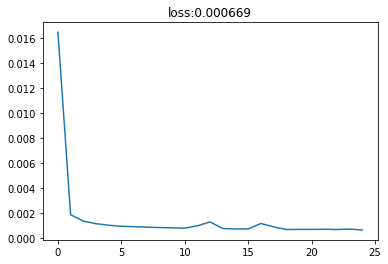

In [33]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.04033578758797851
-0.7235582213786773


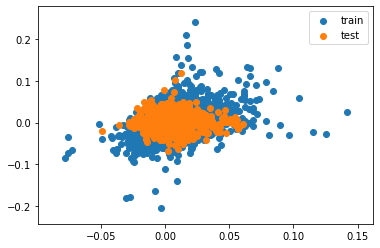

In [34]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

In [35]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7f8128230950>


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
3529/3529 [==============================] - 1s 276us/step - loss: 0.6646
Epoch 2/25
3529/3529 [==============================] - 0s 54us/step - loss: 0.2125
Epoch 3/25
3529/3529 [==============================] - 0s 54us/step - loss: 0.1116
Epoch 4/25
3529/3529 [==============================] - 0s 61us/step - loss: 0.0873
Epoch 5/25
3529/3529 [==============================] - 0s 54us/step - loss: 0.0798
Epoch 6/25
3529/3529 [==============================] - 0s 56us/step - loss: 0.0739
Epoch 7/25
3529/3529 [==============================] - 0s 58us/step - loss: 0.0692
Epoch 8/25
3529/3529 [==============================] - 0s 54us/step - loss: 0.0565
Epoch 9/25
3529/3529 [==============================] - 0s 57us/step - loss: 0.0793
Epoch 10/25
3529/3529 [==============================] - 0s 57us/step - loss: 0.0611
Epoch 11/25
3529/3529 [==============================] - 0s 55us

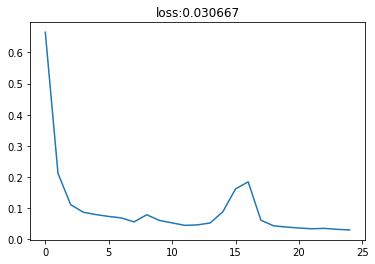

In [36]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.08629465712739415
-0.33583340811791706


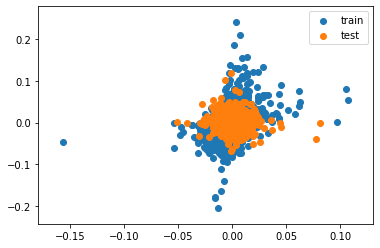

In [37]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/25
3529/3529 [==============================] - 1s 303us/step - loss: 0.0262
Epoch 2/25
3529/3529 [==============================] - 0s 66us/step - loss: 0.0069
Epoch 3/25
3529/3529 [==============================] - 0s 62us/step - loss: 0.0035
Epoch 4/25
3529/3529 [==============================] - 0s 58us/step - loss: 0.0022
Epoch 5/25
3529/3529 [==============================] - 0s 64us/step - loss: 0.0018
Epoch 6/25
3529/3529 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 7/25
3529/3529 [==============================] - 0s 56us/step - loss: 0.0012
Epoch 8/25
3529/3529 [==============================] - 0s 64us/step - loss: 9.6428e-04
Epoch 9/25
3529/3529 [==============================] - 0s 58us/step - loss: 9.3221e-04
Epoch 10/25
3529/3529 [==============================] - 0s 62us/step - loss: 9.1271e-04
Epoch 11/25
3529/3529 [========

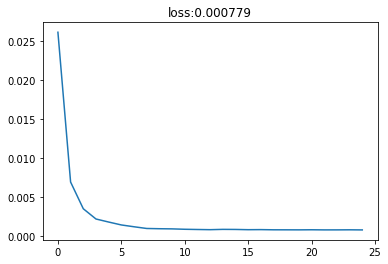

In [38]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [39]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[0.01287378 0.004307   0.01232645 0.01424656 0.01246542]


0.14571687754203033
-0.1270452562431179


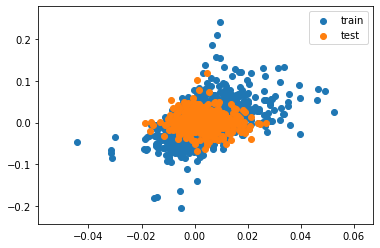

In [40]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()